# Setup

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn')

<ipython-input-1-4207b9e5b9de>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Utility

In [2]:
# Create sequences for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data

## Data Fetching and loading

In [4]:
# Define the date range
start_date = '2018-01-01'
end_date = '2023-08-01'

# Fetch Bitcoin data from Yahoo Finance
data = yf.download('BTC-USD', start=start_date, end=end_date)

# Extract the 'Close' prices and the corresponding dates
close_prices = data['Close'].values
dates = data.index

[*********************100%%**********************]  1 of 1 completed


## Data Exploration

In [5]:
data.shape

(2038, 6)

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-27,29353.798828,29560.966797,29099.351562,29210.689453,29210.689453,10770779217
2023-07-28,29212.164062,29521.513672,29125.845703,29319.246094,29319.246094,11218474952
2023-07-29,29319.445312,29396.843750,29264.166016,29356.917969,29356.917969,6481775959
2023-07-30,29357.093750,29443.169922,29059.501953,29275.308594,29275.308594,8678454527
2023-07-31,29278.314453,29489.873047,29131.578125,29230.111328,29230.111328,11656781982


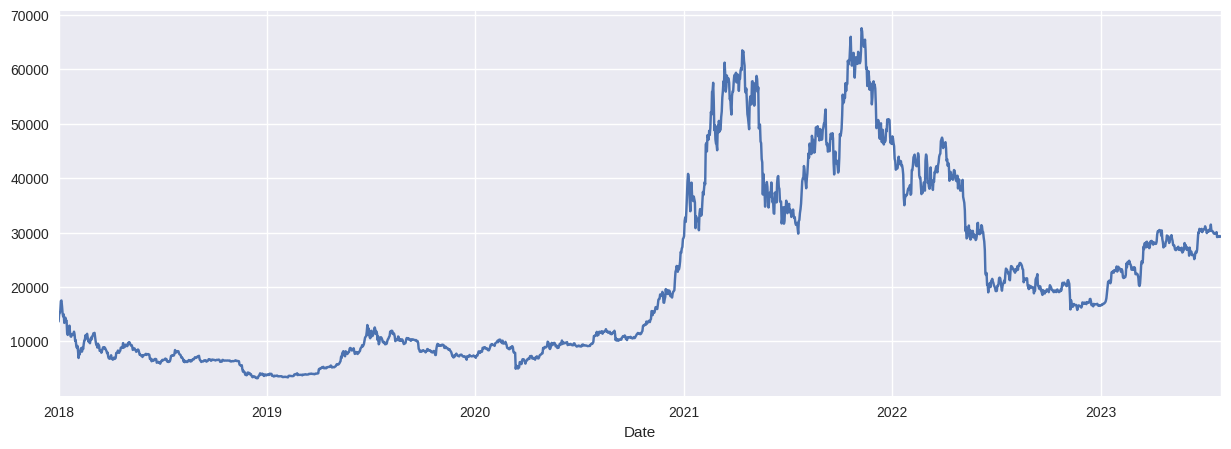

In [8]:
data['Close'].plot(figsize=(15, 5));

## Data spliting

In [9]:
# Split data into training (80%) and testing (20%) sets
train_size = int(len(close_prices) * 0.8)
test_size = len(close_prices) - train_size
train_data, test_data = close_prices[0:train_size], close_prices[train_size:]
train_dates, test_dates = dates[:train_size], dates[train_size:]

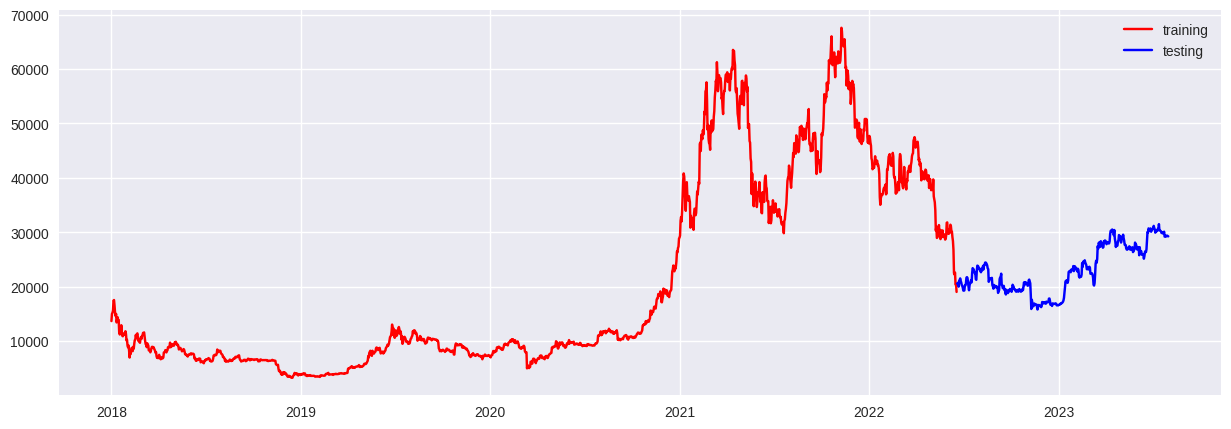

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(train_dates, train_data, label='training', color='red')
plt.plot(test_dates, test_data, label='testing', color='blue')
plt.legend();

## Data Preprocessing

In [11]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [12]:
seq_length = 10  # Adjust the sequence length as needed
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:]
X_test = create_sequences(test_data, seq_length)
y_test = test_data[seq_length:]

# Model

In [13]:
# Build an LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(seq_length, 1), return_sequences=True)))
model.add(Bidirectional(LSTM(80, return_sequences=True)))
model.add(Bidirectional(LSTM(80, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Train the model
r = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=530,
    batch_size=64
)

Epoch 1/530
26/26 [==============================] - 30s 107ms/step - loss: 0.0213 - val_loss: 0.0046
Epoch 2/530
26/26 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 3.8522e-04
Epoch 3/530
26/26 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 3.4632e-04
Epoch 4/530
26/26 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 3.8172e-04
Epoch 5/530
26/26 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 3.5869e-04
Epoch 6/530
26/26 [==============================] - 0s 16ms/step - loss: 9.4713e-04 - val_loss: 3.1278e-04
Epoch 7/530
26/26 [==============================] - 0s 16ms/step - loss: 9.5995e-04 - val_loss: 3.0475e-04
Epoch 8/530
26/26 [==============================] - 0s 16ms/step - loss: 9.2144e-04 - val_loss: 4.0034e-04
Epoch 9/530
26/26 [==============================] - 0s 16ms/step - loss: 9.6860e-04 - val_loss: 2.8210e-04
Epoch 10/530
26/26 [==============================

## Model Evaluation

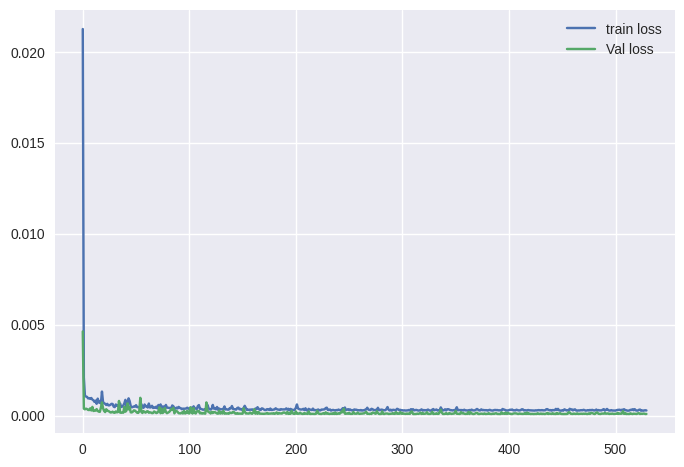

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='Val loss')
plt.legend();

In [15]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the scaled predictions and original values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

13/13 [==============================] - 3s 8ms/step


In [16]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 609.24
MAPE: 1.82%


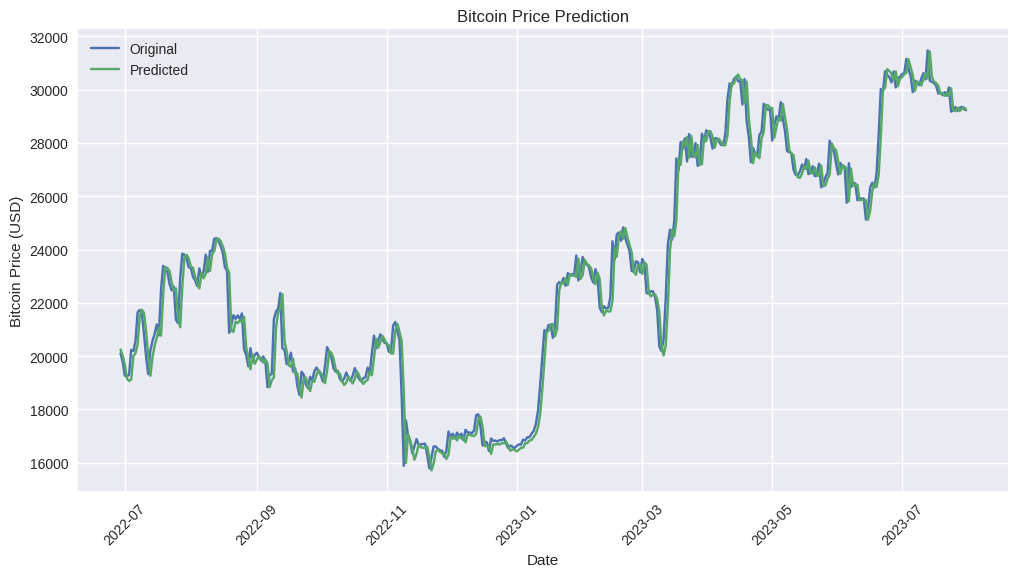

In [17]:
# Plot the predicted vs. original values with dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates[seq_length:], y_test, label='Original')
plt.plot(test_dates[seq_length:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.title('Bitcoin Price Prediction')
plt.xticks(rotation=45)
plt.show()